## Import librairies

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 5.6/5.6 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 GB 135.6 kB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [2]:
import torch
import numpy as np 
import os
import pandas as pd
import tqdm 
from tqdm import tqdm, trange

from sklearn.metrics import accuracy_score, confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler

from utils import run_model_eval, run_model
from models.cnn import CNNClassifier
from utils import is_early_stopping

In [5]:
# Run if File pickle already exists in folder
import pickle

with open('./DeepFake_Real_Sounds.pkl', 'rb') as file:
    data_final = pickle.load(file)


In [56]:
# stride=1
# padding=1
# kernel_size=3
# dilation=1
# l_in=128
# formula=((l_in +2*padding -dilation*(kernel_size-1)-1)/stride) +1
# print(formula)

128.0


## Train, Test and Eval Splits with a weighted oversampling on the training set

In [46]:
embeddings = np.array(data_final['embedding'].tolist())
labels = (data_final['label']).values



X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)

X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.22, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
y_eval_tensor = torch.tensor(y_eval, dtype=torch.float32).view(-1,1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader
batch_size = 32
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in y_train])

sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=sampler)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Ratio of each Class

Here we check that our oversampling in the training set was succesfully done, what is expected is to have a 50/50 distribution of the classes in the training set

In [130]:
count_label_0 = 0
count_label_1 = 0


for _, labels in train_loader:
    count_label_0 += torch.sum(labels == 0)
    count_label_1 += torch.sum(labels == 1)


total_labels = count_label_0 + count_label_1

percentage_label_0 = (count_label_0 / total_labels) * 100
percentage_label_1 = (count_label_1 / total_labels) * 100

print(f"Pourcentage de labels 0 : {percentage_label_0:.2f}%")
print(f"Pourcentage de labels 1 : {percentage_label_1:.2f}%")


Pourcentage de labels 0 : 49.95%
Pourcentage de labels 1 : 50.05%


We then put our system in the GPU mode in order to execute operations in a faster way, the GPU device used here is a RTX 3060 LAPTOP GPU

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Training of the CNNClassifier

In [172]:
from flopth import flopth

model_flops = CNNClassifier()  
input = torch.randn(32,1,128)  


flops, params = flopth(model_flops, inputs=(input,), show_detail=True)
print(f"Flops :{flops}")


+---------------+---------------+------------+-------------+------------------------------+----------+------------------+-------------------------------+----------+-----------------+--------------------------------------------------+
| module_name   | module_type   | in_shape   | out_shape   | kernel_size,padding,stride   | params   | params_percent   | params_percent_vis            | flops    | flops_percent   | flops_percent_vis                                |
+===============+===============+============+=============+==============================+==========+==================+===============================+==========+=================+==================================================+
| conv1         | Conv1d        | (1,128)    | (64,128)    | k=(3,), p=(1,), s=(1,)       | 256.0    | 1.22318%         |                               | 1.04858M | 2.0%            | #                                                |
+---------------+---------------+------------+-------------+----

In [189]:
all_results_json=[]

In [175]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
num_epochs=300
factor=0.1
patience=20
stopping_rate = 1e-3
learning_rate=0.01
momentum=0.9
timings=[]

model = CNNClassifier().to(device)
optimizer = optim.SGD(model.parameters(), lr= learning_rate,momentum=momentum)
loss_function = nn.BCEWithLogitsLoss()
scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience, verbose=True)

train_loss_plot=[]
valid_loss_plot=[]

train_acc_plot=[]
valid_acc_plot=[]

epochs=[]
# GPU WARM UP IN CASE FIRST EXECUTION :
# for epoch in trange(3):
#     print("WARMING UP FOR GPU")
#     train_losses,train_accuracy=run_model(model=model,optimizer=optimizer,timer_starter=None,timer_ender=None,loader=train_loader,loss_function=loss_function,mode='train')


# 
for epoch in trange(num_epochs):
    train_losses,train_accuracy = run_model(model=model,optimizer=optimizer,device=device,loader=train_loader,loss_function=loss_function,timings=timings,mode='train')
    valid_losses,valid_accuracy = run_model(model=model,optimizer=optimizer,loader=test_loader,device=device,loss_function=loss_function,timings=timings,mode='eval')
    

    train_loss = sum(train_losses) / len(train_losses)
    valid_loss = sum(valid_losses) / len(valid_losses)
    train_acc = sum(train_accuracy) / len(train_accuracy)
    valid_acc = sum(valid_accuracy) / len(valid_accuracy)
    
    train_acc_plot.append(train_acc)
    train_loss_plot.append(train_loss)
    valid_acc_plot.append(valid_acc)
    valid_loss_plot.append(valid_loss)

    epochs.append(epoch)


    print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    stop = is_early_stopping(scheduler=scheduler,loss=valid_acc,optimizer=optimizer,stopping_rate=stopping_rate,elder_learning_rate=learning_rate,condition='improvement')
    if stop == True:
        print(f"Early stopping for a learning rate = {optimizer.param_groups[0]['lr']}")
        break

all_results_json.append({ 'model' : { 'architecture' :str(model), 'FLOPS' : flops},
                         'parameters' : {
                                    'learning_rate': learning_rate,
                                    'reduction factor' : factor, 
                                    'patience' : patience, 
                                    'momentum' : momentum,
                                    'batch_size': batch_size},
                           'results' : {
                                    'train_loss': train_loss_plot,
                                    'valid_loss': valid_loss_plot,
                                    'train_accuracy': train_acc_plot,
                                    'valid_accuracy': valid_acc_plot,
                                    'Number of epochs' : epochs[-1],
                                    'Early stop' : stop,
                                    'final learning_rate' : optimizer.param_groups[0]['lr']}})

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:06<30:42,  6.16s/it]

[Epoch 1/300] [Train Loss: 0.6782] [Train Acc: 0.7365] [Valid Loss: 0.4476] [Valid Acc: 0.7816]


  1%|          | 2/300 [00:10<26:36,  5.36s/it]

[Epoch 2/300] [Train Loss: 0.4565] [Train Acc: 0.7809] [Valid Loss: 0.4413] [Valid Acc: 0.7864]


  1%|          | 3/300 [00:15<25:05,  5.07s/it]

[Epoch 3/300] [Train Loss: 0.4298] [Train Acc: 0.7999] [Valid Loss: 0.3925] [Valid Acc: 0.8125]


  1%|▏         | 4/300 [00:20<25:02,  5.08s/it]

[Epoch 4/300] [Train Loss: 0.4178] [Train Acc: 0.8054] [Valid Loss: 0.4904] [Valid Acc: 0.7593]


  2%|▏         | 5/300 [00:26<26:21,  5.36s/it]

[Epoch 5/300] [Train Loss: 0.4115] [Train Acc: 0.8110] [Valid Loss: 0.3825] [Valid Acc: 0.8228]


  2%|▏         | 6/300 [00:31<25:39,  5.23s/it]

[Epoch 6/300] [Train Loss: 0.4005] [Train Acc: 0.8197] [Valid Loss: 0.3449] [Valid Acc: 0.8476]


  2%|▏         | 7/300 [00:36<24:46,  5.07s/it]

[Epoch 7/300] [Train Loss: 0.3994] [Train Acc: 0.8182] [Valid Loss: 0.3283] [Valid Acc: 0.8531]


  3%|▎         | 8/300 [00:40<23:03,  4.74s/it]

[Epoch 8/300] [Train Loss: 0.3893] [Train Acc: 0.8272] [Valid Loss: 0.4422] [Valid Acc: 0.7928]


  3%|▎         | 9/300 [00:44<22:08,  4.57s/it]

[Epoch 9/300] [Train Loss: 0.3814] [Train Acc: 0.8305] [Valid Loss: 0.4874] [Valid Acc: 0.7642]


  3%|▎         | 10/300 [00:48<21:08,  4.37s/it]

[Epoch 10/300] [Train Loss: 0.3749] [Train Acc: 0.8315] [Valid Loss: 0.4279] [Valid Acc: 0.8086]


  4%|▎         | 11/300 [00:52<20:17,  4.21s/it]

[Epoch 11/300] [Train Loss: 0.3741] [Train Acc: 0.8307] [Valid Loss: 0.3725] [Valid Acc: 0.8322]


  4%|▍         | 12/300 [00:56<19:54,  4.15s/it]

[Epoch 12/300] [Train Loss: 0.3706] [Train Acc: 0.8351] [Valid Loss: 0.3262] [Valid Acc: 0.8515]


  4%|▍         | 13/300 [01:01<21:29,  4.49s/it]

[Epoch 13/300] [Train Loss: 0.3601] [Train Acc: 0.8397] [Valid Loss: 0.3228] [Valid Acc: 0.8534]


  5%|▍         | 14/300 [01:07<22:49,  4.79s/it]

[Epoch 14/300] [Train Loss: 0.3553] [Train Acc: 0.8435] [Valid Loss: 0.3888] [Valid Acc: 0.8241]


  5%|▌         | 15/300 [01:12<24:13,  5.10s/it]

[Epoch 15/300] [Train Loss: 0.3519] [Train Acc: 0.8471] [Valid Loss: 0.3769] [Valid Acc: 0.8280]


  5%|▌         | 16/300 [01:18<24:57,  5.27s/it]

[Epoch 16/300] [Train Loss: 0.3502] [Train Acc: 0.8468] [Valid Loss: 0.4434] [Valid Acc: 0.7951]


  6%|▌         | 17/300 [01:24<25:14,  5.35s/it]

[Epoch 17/300] [Train Loss: 0.3472] [Train Acc: 0.8475] [Valid Loss: 0.3681] [Valid Acc: 0.8370]


  6%|▌         | 18/300 [01:32<28:54,  6.15s/it]

[Epoch 18/300] [Train Loss: 0.3397] [Train Acc: 0.8500] [Valid Loss: 0.3713] [Valid Acc: 0.8260]


  6%|▋         | 19/300 [01:36<26:50,  5.73s/it]

[Epoch 19/300] [Train Loss: 0.3352] [Train Acc: 0.8561] [Valid Loss: 0.4193] [Valid Acc: 0.8131]


  7%|▋         | 20/300 [01:41<25:15,  5.41s/it]

[Epoch 20/300] [Train Loss: 0.3364] [Train Acc: 0.8544] [Valid Loss: 0.4290] [Valid Acc: 0.8183]


  7%|▋         | 21/300 [01:46<24:12,  5.21s/it]

[Epoch 21/300] [Train Loss: 0.3360] [Train Acc: 0.8555] [Valid Loss: 0.4922] [Valid Acc: 0.7825]


  7%|▋         | 22/300 [01:51<23:31,  5.08s/it]

[Epoch 22/300] [Train Loss: 0.3343] [Train Acc: 0.8550] [Valid Loss: 0.3877] [Valid Acc: 0.8257]


  8%|▊         | 23/300 [01:56<23:15,  5.04s/it]

[Epoch 23/300] [Train Loss: 0.3231] [Train Acc: 0.8587] [Valid Loss: 0.3438] [Valid Acc: 0.8392]


  8%|▊         | 24/300 [02:00<22:46,  4.95s/it]

[Epoch 24/300] [Train Loss: 0.3269] [Train Acc: 0.8610] [Valid Loss: 0.3663] [Valid Acc: 0.8389]


  8%|▊         | 25/300 [02:05<22:59,  5.02s/it]

[Epoch 25/300] [Train Loss: 0.3283] [Train Acc: 0.8587] [Valid Loss: 0.4591] [Valid Acc: 0.8028]


  9%|▊         | 26/300 [02:11<23:05,  5.06s/it]

[Epoch 26/300] [Train Loss: 0.3202] [Train Acc: 0.8638] [Valid Loss: 0.3506] [Valid Acc: 0.8476]


  9%|▉         | 27/300 [02:15<22:43,  4.99s/it]

[Epoch 27/300] [Train Loss: 0.3193] [Train Acc: 0.8629] [Valid Loss: 0.4061] [Valid Acc: 0.8231]


  9%|▉         | 28/300 [02:23<26:13,  5.78s/it]

[Epoch 28/300] [Train Loss: 0.3161] [Train Acc: 0.8628] [Valid Loss: 0.3966] [Valid Acc: 0.8225]


 10%|▉         | 29/300 [02:29<25:49,  5.72s/it]

[Epoch 29/300] [Train Loss: 0.3199] [Train Acc: 0.8660] [Valid Loss: 0.3297] [Valid Acc: 0.8521]


 10%|█         | 30/300 [02:34<24:57,  5.55s/it]

[Epoch 30/300] [Train Loss: 0.3145] [Train Acc: 0.8686] [Valid Loss: 0.3313] [Valid Acc: 0.8531]


 10%|█         | 31/300 [02:39<24:15,  5.41s/it]

[Epoch 31/300] [Train Loss: 0.3147] [Train Acc: 0.8638] [Valid Loss: 0.3763] [Valid Acc: 0.8373]


 11%|█         | 32/300 [02:44<24:16,  5.44s/it]

[Epoch 32/300] [Train Loss: 0.3068] [Train Acc: 0.8702] [Valid Loss: 0.3807] [Valid Acc: 0.8312]


 11%|█         | 33/300 [02:50<23:48,  5.35s/it]

[Epoch 33/300] [Train Loss: 0.3059] [Train Acc: 0.8704] [Valid Loss: 0.3480] [Valid Acc: 0.8483]


 11%|█         | 33/300 [02:56<23:44,  5.34s/it]

[Epoch 34/300] [Train Loss: 0.3055] [Train Acc: 0.8707] [Valid Loss: 0.3867] [Valid Acc: 0.8367]
Epoch 00034: reducing learning rate of group 0 to 1.0000e-03.
Early stopping for a learning rate = 0.001


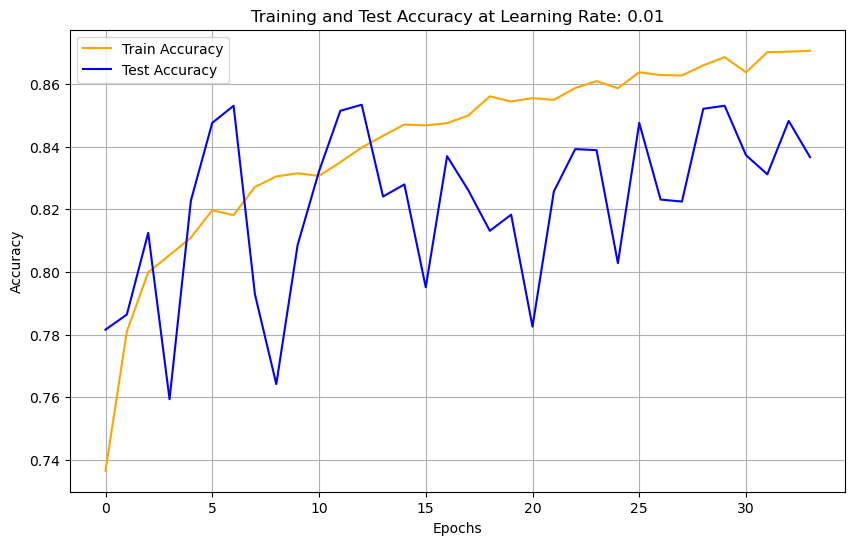

In [176]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6)) 
plt.plot(epochs,train_acc_plot, label='Train Accuracy', color='orange')
plt.plot(epochs,valid_acc_plot, label='Test Accuracy', color='blue')
plt.title(f'Training and Test Accuracy at Learning Rate: {learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
mean_syn = np.sum(timings) / ((epoch+1)*1000)
print(f"The time of training for the CNN model : {mean_syn} s/epoch")

The time of training for the CNN model : 2.317220040636904 s/epoch


In [178]:
all_results_json[-1]['results']['Time of training'] = mean_syn

In [179]:
torch.cuda.get_device_properties(device=torch.device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)

In [180]:
all_results_json[-1]['parameters']['device GPU'] = torch.cuda.get_device_properties(device=torch.device)

## Prediction on Test set + Confusion Matrix computation

In [181]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
timings=[] 
accuracy,conf_matrix= run_model_eval(model=model,loader=eval_loader,device=device,timings=timings)
    

print(f'Accuracy: {accuracy * 100:.2f}%')

print('Confusion Matrix:\n', conf_matrix)

all_results_json[-1]['results']['eval_accuracy'] = accuracy
all_results_json[-1]['results']['confusion_matrix'] = conf_matrix.tolist()


Accuracy: 81.80%
Confusion Matrix:
 [[4111  901]
 [ 207  870]]


In [171]:
import json

filename = './results_models.json'
results_json = json.dumps(all_results_json, indent=4)
with open(filename, 'w') as file:
    file.write(results_json)

print(f"Results have been saved to {filename}")

Results have been saved to ./results_models.json


In [ ]:
import matplotlib.pyplot as plt


n_rows = len(all_results_json)  
n_cols = 3 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))  

for i, result in enumerate(all_results_json):
    ax = axes[i] if n_rows > 1 else axes  
    params = result['parameters']
    res = result['results']
    
    ax.plot(res['train_loss'], label='Train Loss', color='red')
    ax.plot(res['valid_loss'], label='Validation Loss', color='green')
    
    ax2 = ax.twinx()  
    ax2.plot(res['train_accuracy'], label='Train Accuracy', color='blue', linestyle='--')
    ax2.plot(res['valid_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
    
    title = f"LR: {params['learning_rate']}, Reduction: {params['reduction factor']}, "
    title += f"Patience: {params['patience']}, Momentum: {params['momentum']}"
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy (%)')
    
    # Légendes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Ajustez l'espacement
plt.tight_layout()

# Affichez la figure
plt.show()
